In [1]:
# Ritter IPO Analysis
#   Step 1: Import and Clean Ritter IPO datasets
# pip install wget

#imports
import numpy as np
import pandas as pd
import math
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import wget

In [2]:
# Download Ritter IPO 2609 file
ipo2609_filename = "IPO2609.xls"
url = "https://site.warrington.ufl.edu/ritter/files/2016/01/IPO2609.xls"
wget.download(url, ipo2609_filename)

100% [............................................................................] 828416 / 828416

'IPO2609.xls'

In [3]:
# Download Ritter IPO 1526 file
ipo1526_filename = "IPO1526.xls"
url = "https://site.warrington.ufl.edu/ritter/files/2016/01/IPO1526.xls"
wget.download(url, ipo1526_filename)

100% [..........................................................................] 1399808 / 1399808

'IPO1526.xls'

In [4]:
# Read Excel file into dataframe
# NOTE:  YOu can igore WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
df = pd.read_excel(ipo2609_filename, sheet_name='ipo2609')

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [5]:
# Clean Zip Codes and generate zip3
#   Replace 0, 999 with 00000
df['zip'] = df['zip'].astype(str).str.ljust(5, '0')
df['zip'] = df['zip'].replace(
    to_replace=['99900'],
    value='00000')
#      Add trailing zeros so 5 digits
#df['zip'] = pd.Categorical(df['zip'])
#      Use zip3 for region
df['zip3'] = df['zip'].str[:3].astype("int")

#   Security Type: Last two digits of CUSIP represent security type
df['sectype'] = df['cusip'].astype(str).str[-2:].astype("int")

# Convert Categorical
#   Type
#      Create a type code
df['t_code'] = df['t'].copy().astype("int")
#      There are two NA values 0,9.  Use 9 only
df['t_code'] = df['t_code'].replace(
    to_replace=[0],
    value=9)
df['t'] = df['t'].replace(
    to_replace=[0, 9],
    value='NA')
df['t'] = df['t'].replace(
    to_replace=[1],
    value='Best Efforts')
df['t'] = df['t'].replace(
    to_replace=[2],
    value='Firm Committment')
df['t'] = df['t'].replace(
    to_replace=[3],
    value='Combination')
df['t'] = pd.Categorical(df['t'])
#   Exchange
#      Create an exchange code
df['ex_code'] = df['ex'].copy().astype("int")
df['ex'] = df['ex'].replace(
    to_replace=[1],
    value='NASDAQ')
df['ex'] = df['ex'].replace(
    to_replace=[2],
    value='AMEX')
df['ex'] = df['ex'].replace(
    to_replace=[3],
    value='NYSE')
df['ex'] = df['ex'].replace(
    to_replace=[4],
    value='Non_NASDAQ_OTC')
df['ex'] = pd.Categorical(df['ex'])

# Clean Up Integer Fields
df['odate'] = df['odate'].astype("int")
#   SIC Code
#     999 represents missing
df['sic'] = df['sic'].astype("int")
#     Add 2-digit group code
df['sic_group'] = df['sic'].apply(lambda x: math.floor(x / 10)).astype("int")

#   Lead Underwriter
#      0 represents missing
#      Add group -- see Ritter documentation
df['uw1'] = df['uw1'].astype("int")
df['uw1_group'] = df['uw1'].apply(lambda x: math.floor(x / 100) * 100).astype("int")
#   Other underwriters
df['uw2'] = df['uw2'].astype("int")
df['uw2_group'] = df['uw2'].apply(lambda x: math.floor(x / 10) * 10).astype("int")
df['uw3'] = df['uw3'].astype("int")
df['uw3_group'] = df['uw3'].apply(lambda x: math.floor(x / 10)).astype("int")
#   NOTE: uw4 and uwS (should be 5) dropped below.  Just use first three underwriters
#   Year Organized
#     99 represents missing
df['yr'] = df['yr'].astype("int")
#   Perm (Key to join 1526 file)
df['perm'] = df['perm'].astype("int")

# Convert and scale decimals
#   Offering Price 7.3
df['op'] = df['op'].astype(float) / 1000
#   Closing bid on first aftermarket day 9.5
df['pr1'] = df['pr1'].astype(float) / 100000
#   Value of S&P on Closing Date 5.2
df['sp'] = df['sp'].replace(
    to_replace=[99999],
    value=np.NaN)
df['sp'] = df['sp'].astype(float) / 100
#   Aftermarket standard deviation
df['uncer'] = df['uncer'].replace(
    to_replace=[999],
    value=np.NaN)
df['uncer'] = df['uncer'].astype(float) / 1000
#   Continuousely compounded growth rate
df['gs'] = df['gs'].replace(
    to_replace=[999],
    value=np.NaN)
df['gs'] = df['gs'].astype(float) / 1000
#   Offering as a fraction of shares outstanding
df['of'] = df['of'].replace(
    to_replace=[999],
    value=np.NaN)
df['of'] = df['of'].astype(float) / 100

# Review columns with missing values
# uncer 757
# gs 1506
# of 37
df.isnull().sum()

# Drop columns uncer and gs as well as cusip, zip and uw3,4,5
df = df.drop(['uncer', 'gs', 'cusip', 'zip', 'uw3', 'uw4', 'uwS'], axis=1)

# Drop rows with missing data
df = df[df['op'] != 0]
df = df[df['sic'] != 999]
df = df[df['t'] != 'NA']
df = df[~df['of'].isnull()]

# Calculate D1 percent change in price
df['d1pctchg'] = (df['pr1'] - df['op']) / df['op'] * 100
# Calculate underpriced flag
df['underpriced'] = df['d1pctchg'] > 0

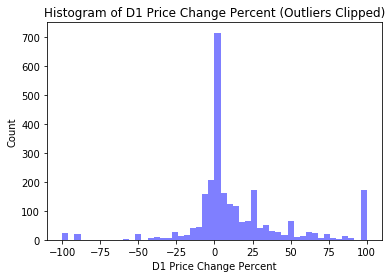

In [6]:
# Plot a Histogram of D1 Price Change Percent
# Remove NaN and Clip Outliers
clipped= np.clip(df['d1pctchg'][~np.isnan(df['d1pctchg'])], -100, 100)
num_bins = 50
n, bins, patches = plt.hist(clipped, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('D1 Price Change Percent')
plt.ylabel('Count')
plt.title(r'Histogram of D1 Price Change Percent (Outliers Clipped)')
plt.show()

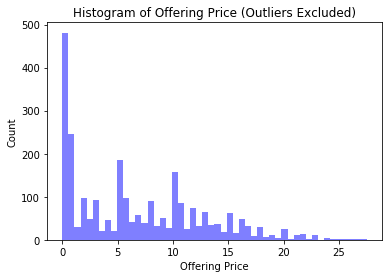

In [7]:
# Simple Outlier implementation based on z-score
def is_outlier(points, thresh=3.0):

    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


# Plot a Histogram of Offering Price excluding outliers
filtered = df['op'][~is_outlier(df['op'])]
num_bins = 50
n, bins, patches = plt.hist(filtered, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Offering Price')
plt.ylabel('Count')
plt.title(r'Histogram of Offering Price (Outliers Excluded)')
plt.show()

In [8]:
# Join IPO1526 (36 month returns for CRSP-listed)
# Parse columns returns perm and 38 months of returns
df_1526 = pd.read_excel(
    ipo1526_filename, sheet_name='ipo1526', usecols='B,T:BE')

# Replace missing values -100 with NaN for all 38 month return columns
for x in range(1, 39):
    r_col_name = 'r' + str(x)
    df_1526[r_col_name] = df_1526[r_col_name].mask(
        np.isclose(df_1526[r_col_name].values, -99.99998))


# Calculate 12, 24 and 36 month returns
df_1526['r12_sum'] = df_1526.iloc[:, 2:14].sum(axis=1) * 100
df_1526['r24_sum'] = df_1526.iloc[:, 2:26].sum(axis=1) * 100
df_1526['r36_sum'] = df_1526.iloc[:, 2:38].sum(axis=1) * 100

df_1526['r36_sum'].mean()

# Drop r1-r38 columns
for x in range(1, 39):
    r_col_name = 'r' + str(x)
    df_1526.drop(r_col_name, inplace=True, axis=1)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [9]:
# In Professor Ritter's 1991 paper, The Long-Run Performance of Initial Public Offerings
#  he indicates that the average period return for these 1526 stocks
#  in the 3 years after going public is 34.47%
# However, based on the data in the Excel file, I am getting a higher value (39.52%)
#  At this point, I can see no cause for the discrepancy
#  For the purposes of this experiment, I will ignore this discrepancy
df_1526['r36_sum'].mean()

39.52541677588471

In [10]:
# Merge on Perm
df_1526['perm'] = df_1526['perm'].astype("int")
df_merged = pd.merge(df, df_1526, on='perm')

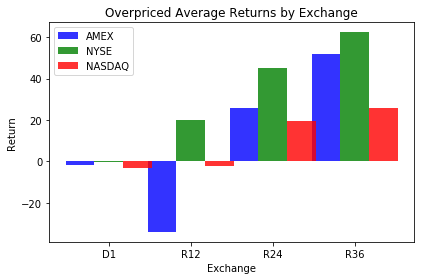

In [11]:
# Plot Bar Charts of Average Returns by Exchange for Overpriced and underpriced

#    Overpriced Chart
df_bar = df_merged[['underpriced', 'ex', 'd1pctchg', 'r12_sum', 'r24_sum', 'r36_sum']]
df_bar = df_bar.groupby(['underpriced', 'ex']).mean()
df_over_amex = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'AMEX')]
df_over_amex = df_over_amex.values.tolist()[0]
df_over_nyse = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'NYSE')]
df_over_nyse = df_over_nyse.values.tolist()[0]
df_over_nasdaq = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'NASDAQ')]
df_over_nasdaq = df_over_nasdaq.values.tolist()[0]

n_groups = 4
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, df_over_amex, bar_width,
    alpha=opacity,
    color='b',
    label='AMEX')
rects2 = plt.bar(index + bar_width, df_over_nyse, bar_width,
    alpha=opacity,
    color='g',
    label='NYSE')
rects3 = plt.bar(index + bar_width * 2, df_over_nasdaq, bar_width,
    alpha=opacity,
    color='r',
    label='NASDAQ')
plt.xlabel('Exchange')
plt.ylabel('Return')
plt.title('Overpriced Average Returns by Exchange')
plt.xticks(index + bar_width, ('D1', 'R12', 'R24', 'R36'))
plt.legend()
plt.tight_layout()
plt.show()

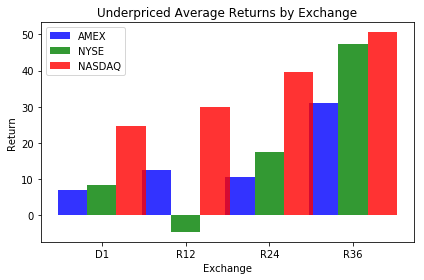

In [12]:
#    UnderPriced Chart
df_under_amex = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'AMEX')]
df_under_amex = df_under_amex.values.tolist()[0]
df_under_nyse = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'NYSE')]
df_under_nyse = df_under_nyse.values.tolist()[0]
df_under_nasdaq = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'NASDAQ')]
df_under_nasdaq = df_under_nasdaq.values.tolist()[0]

n_groups = 4
fig, ax = plt.subplots()
index = np.arange(n_groups)
rects1 = plt.bar(index, df_under_amex, bar_width,
    alpha=opacity,
    color='b',
    label='AMEX')
rects2 = plt.bar(index + bar_width, df_under_nyse, bar_width,
    alpha=opacity,
    color='g',
    label='NYSE')
rects3 = plt.bar(index + bar_width * 2, df_under_nasdaq, bar_width,
    alpha=opacity,
    color='r',
    label='NASDAQ')
plt.xlabel('Exchange')
plt.ylabel('Return')
plt.title('Underpriced Average Returns by Exchange')
plt.xticks(index + bar_width, ('D1', 'R12', 'R24', 'R36'))
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Step 2: Feature Engineering
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

# Convert odate to YYYYMM
df['odate'] = df['odate'].astype(str).str[:4].astype("int")

In [14]:
# Univariate Feature Selection
uni_vars=df.columns.values.tolist()

uni_vars.remove('underpriced') # The value we are predicting, so remove from factors
uni_vars.remove('Name') # Company identifier, not relevant
uni_vars.remove('perm') # permanent identifier, not relevant
uni_vars.remove('dt1') # Price after first day trading, unknown at time of prediction
uni_vars.remove('d1pctchg') # Price percent change after first day trading, unknown at time of prediction
uni_vars.remove('ex') # use numeric ex_code
uni_vars.remove('t') # Use numeric t_code
uni_X = df[uni_vars]
uni_y = df['underpriced']

# Apply SelectKBest class to extract top 15 best features
# Use mutual_info_classif
bestfeatures = SelectKBest(score_func=mutual_info_classif,k=15)
fit = bestfeatures.fit(uni_X, uni_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(uni_X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(15, 'Score'))

      Specs     Score
4       pr1  0.130528
0     odate  0.039736
6        sp  0.033173
3        op  0.029974
23     zip3  0.028643
7       uw1  0.025486
9        sh  0.019542
24  sectype  0.018687
22    audit  0.016802
11      max  0.016015
17     book  0.013754
18        d  0.013137
5       sic  0.010957
15   lockup  0.010003
26  ex_code  0.009649


In [15]:
# Scale and use chi2
import warnings
with warnings.catch_warnings():
    # ignore data conversion warnings
    warnings.filterwarnings("ignore")
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(uni_X) 
    scaled_X = uni_X.copy()
    scaled_X.loc[:,:] = scaled_values

bestfeatures = SelectKBest(score_func=chi2,k=15)
fit = bestfeatures.fit(scaled_X, uni_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(scaled_X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(15, 'Score'))

        Specs      Score
26    ex_code  16.515713
22      audit   6.769405
23       zip3   4.950410
2         reg   3.961824
1         sel   3.655659
24    sectype   3.549752
25     t_code   2.980285
30  uw3_group   2.951441
21       uses   2.907307
10        min   1.327842
9          sh   1.072479
27  sic_group   0.933019
5         sic   0.889992
11        max   0.853738
3          op   0.686933


In [16]:
# Look for features with low variance
sel = VarianceThreshold(1)
sel.fit_transform(uni_X, uni_y)
# Review retained features (all included)
sel.get_support(indices=True)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30], dtype=int64)

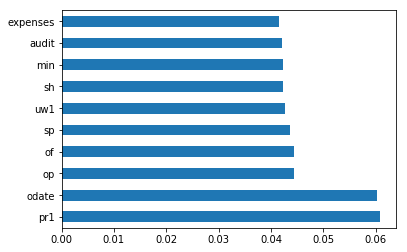

In [17]:
# Feature Importance
model = ExtraTreesClassifier(n_estimators=100)
model.fit(uni_X, uni_y)
feat_importances = pd.Series(model.feature_importances_, index=scaled_X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [18]:
# Categorical Values and Recursive Feature Elimination (RFE)
rfe_vars=df.columns.values.tolist()

rfe_vars.remove('underpriced') # The value we are predicting, so remove from factors
rfe_vars.remove('Name') # Company identifier, not relevant
rfe_vars.remove('perm') # permanent identifier, not relevant
rfe_vars.remove('dt1') # Price after first day trading, unknown at time of prediction
rfe_vars.remove('pr1') # Closing Bid after first day trading, unknown at time of prediction
rfe_vars.remove('d1pctchg') # Price percent change after first day trading, unknown at time of prediction
rfe_vars.remove('ex') # use numeric ex_code
rfe_vars.remove('t') # Use numeric t_code
rfe_X = df[rfe_vars]
rfe_y = df['underpriced']

# Temporarily override chained assignment warning
class ChainedAssignent:
    def __init__(self, chained=None):
        acceptable = [None, 'warn', 'raise']
        assert chained in acceptable, "chained must be in " + str(acceptable)
        self.swcw = chained

    def __enter__(self):
        self.saved_swcw = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = self.swcw
        return self

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = self.saved_swcw


# Scale floating point features for being logistic regression performance
with ChainedAssignent():
    with warnings.catch_warnings():
        # ignore data conversion warnings
        warnings.filterwarnings("ignore")
        rfe_X[['d','audit','op','max','min','sel','uses', 'of', 'expenses', 'risks', 'sp', 'reg']] = scaler.fit_transform(rfe_X[['d','audit','op','max','min','sel','uses', 'of', 'expenses', 'risks', 'sp', 'reg']])


cat_vars = ['odate', 'zip3', 'sic', 'sic_group', 'uw1', 'uw1_group', 'uw2', 'uw2_group', 'yr', 'sectype', 't_code', 'ex_code']
for var in cat_vars:
    var_dummies = pd.get_dummies(rfe_X[var], prefix=var)
    rfe_X = rfe_X.join(var_dummies)

rfe_X_vars = rfe_X.columns.values.tolist()
to_keep=[i for i in rfe_X_vars if i not in cat_vars]
rfe_X = rfe_X[to_keep]

# Perform RFE on categorical features
logreg = LogisticRegression(solver='liblinear')
rfe = RFE(logreg, 20)
# NOTE: This takes several minutes with more than 1000 features
rfe = rfe.fit(rfe_X, rfe_y.values.ravel())

rfe_ranked_features = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), rfe_X))
# Take top 50 features
rfe_features = [t[1] for t in rfe_ranked_features[:50]]
# Take features with rank of 10 or lower
#rfe_features = [t[1] for t in rfe_ranked_features if t[0] <= 10]
print(rfe_features)

['odate_8001', 'odate_8008', 'odate_8009', 'odate_8010', 'odate_8211', 'odate_8303', 'odate_8304', 'odate_8305', 'odate_8306', 'sic_383', 'sic_671', 'sic_group_47', 'uw1_261', 'uw1_328', 'uw1_332', 'uw1_505', 'uw1_609', 'uw1_818', 'yr_1', 'zip3_940', 'odate_8207', 'uw2_111', 'odate_8301', 'uw1_303', 'odate_8212', 'uw1_204', 'd', 'sic_381', 'odate_8405', 'uw1_605', 'odate_8110', 'ex_code_4', 't_code_1', 'odate_8307', 'uw1_109', 'uw2_group_120', 'uw2_group_600', 'odate_8302', 'uw2_group_510', 'yr_67', 'odate_8411', 'uw1_107', 'uw1_311', 'sic_382', 'sic_357', 'odate_8102', 'sic_104', 'uw1_323', 'uw1_group_600', 'odate_8402']


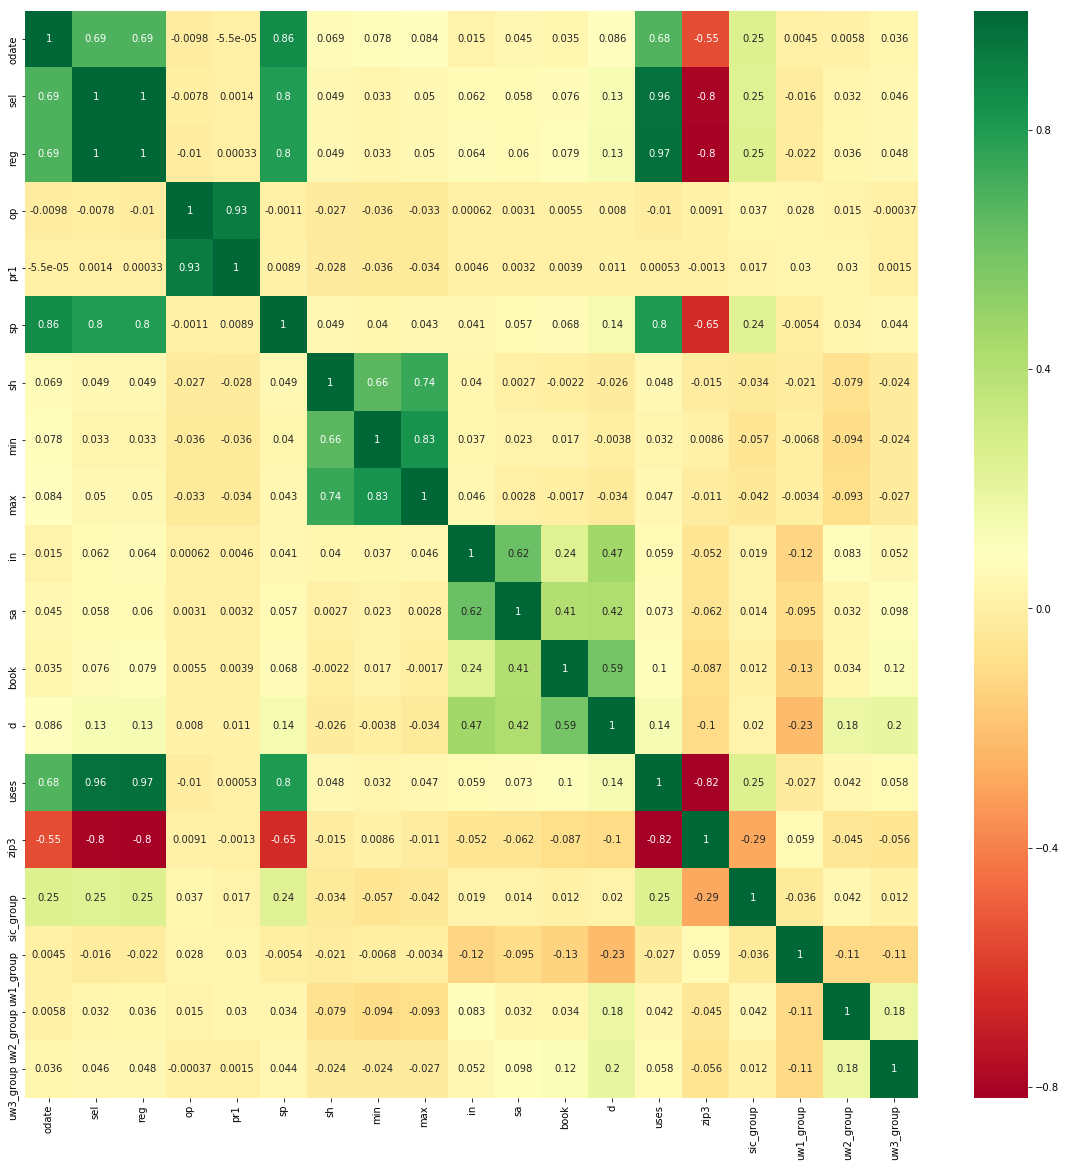

In [19]:
# Correlation Matrix
cor_X = uni_X.copy()
# Drop columns with insignificant correlations so plot is easier to read
cor_X = cor_X.drop(['uw1', 'uw2', 'sectype', 'of', 'ex_code', 't_code', 'audit', 'risks', 'yr', 'sic', 'lockup', 'expenses'], axis=1)
corrmat = cor_X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
# Plot heat map
g=sns.heatmap(cor_X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()

In [20]:
# Specify final vars to keep for training a model
# Start with non-indicator values with most importance, avoiding highly correlated features
# Note: model_vars is a set to avoid dups
model_vars = {'book', 'd', 'audit', 'in', 'lockup', 'op', 'max', 'sel', 'uses', 'of', 'sa', 'sp'}
# Add top 50 RFE features
model_vars.update(rfe_features)
model_df = rfe_X[list(model_vars)]
model_df = model_df.join(uni_y)

In [21]:
# Step 3: Train and evaluate binary classifcation models

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [22]:
# Create Test, Train data sets
ipo_train, ipo_test = train_test_split(model_df, random_state=42)

# Training (X), remove label (y)
features = model_df.columns.drop(["underpriced"])
X = ipo_train[features.values.tolist()]
y = np.ravel(ipo_train["underpriced"])

In [23]:
# SciKit-Learn logistic regression model

sk_log_reg = LogisticRegression(solver='liblinear')
sk_log_model = sk_log_reg.fit(X, y)
probList = []
probList = sk_log_model.predict_proba(ipo_test[features.values.tolist()])[:,1]
probArray = np.asarray(probList)
fpr, tpr, thresholds = roc_curve(ipo_test["underpriced"] , probArray)
aucResult = auc(fpr, tpr)
print ("scikit logistic AUC: " + str(aucResult))

scikit logistic AUC: 0.5467846713153346


In [24]:
# Scikit Random Forest
rfc = RandomForestClassifier(n_estimators=100, random_state = 42)
sk_rf_model = rfc.fit(X, y)
probList = []
probList = sk_rf_model.predict_proba(ipo_test[features.values.tolist()])[:,1]
probArray = np.asarray(probList)
fpr, tpr, thresholds = roc_curve(ipo_test["underpriced"] , probArray)
aucResult = auc(fpr, tpr)
print ("scikit Random Forest Classifier AUC: " + str(aucResult))

scikit Random Forest Classifier AUC: 0.6791078133381012


In [25]:
# Scikit Random Forest Tune Hyperparameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [26]:
# Random search of parameters, using 3 cross validation folds
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1, random_state=42)
# Fit the random search model
rfc_random.fit(X, y)

# Review best hyperparameters
# {'max_depth': None, 'n_estimators': 1118, 'min_samples_leaf': 4, 'min_samples_split': 10, 'max_features': 'sqrt', 'bootstrap': False}
rfc_random.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   36.1s finished


{'n_estimators': 751,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': True}

In [27]:
# Fit a model with the best hyperparameters
rfc_best = RandomForestClassifier(n_estimators=1118, max_depth = None,
                                  min_samples_leaf=4, min_samples_split=10, max_features='sqrt',
                                  bootstrap=False, random_state=42)
sk_rfc_best_model = rfc_best.fit(X, y)
probList = []
probList = sk_rfc_best_model.predict_proba(ipo_test[features.values.tolist()])[:,1]
probArray = np.asarray(probList)
fpr, tpr, thresholds = roc_curve(ipo_test["underpriced"] , probArray)
aucResult = auc(fpr, tpr)
print ("scikit Random Forest Classifier Tuned Hyperparameters AUC: " + str(aucResult))

scikit Random Forest Classifier Tuned Hyperparameters AUC: 0.6871386852613386
